<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/main/projects/ComputerVision/spectrogram_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>  &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/projects/ComputerVision/spectrogram_analysis.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Music classification and generation with spectrograms

**By Neuromatch Academy**

__Content creators:__ Beatrix Benko, Lina Teichmann

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

## This notebook
This notebook loads the GTZAN dataset which includes audiofiles and spectrograms. You can use this dataset or find your own. The first part of the notebook is all about data visualization and show how to make spectrograms from audiofiles. The second part of the notebook includes a CNN that is trained on the spectrograms to predict music genre. Below we also provide links to tutorials and other resources if you want to try to do some of the harder project ideas. 

Have fun :) 


## Acknowledgements
This notebook was written by Beatrix Benkő and Lina Teichmann.

**Useful code examples:** 

https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8

[https://pytorch.org/vision/stable/models.html](https://pytorch.org/vision/stable/models.html)

[https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py](https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py)

https://github.com/kamalesh0406/Audio-Classification 

https://github.com/zcaceres/spec_augment

https://musicinformationretrieval.com/ipython_audio.html 

---
# Setup

In [1]:
# @title Install dependencies
!sudo apt-get install -y ffmpeg --quiet
!pip install librosa --quiet
!pip install imageio --quiet
!pip install imageio-ffmpeg --quiet

/bin/bash: sudo: command not found


In [2]:
# Import necessary libraries.
import os
import glob
import imageio
import random, shutil
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import librosa
import librosa.display

In [3]:
import requests

fname = "music.zip"
url = "https://osf.io/drjhb/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

## Loading GTZAN dataset (includes spectrograms)

The GTZAN dataset for music genre classification can be dowloaded from Kaggle: https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification. 

To download from Kaggle using this code you need to download and copy over your api token. In Kaggle go to the upper right side -> account -> API -> create API token. This downloads a json file. Copy the content into api_token. It should look like this: 

api_token = {"username":"johnsmith","key":"123a123a123"}


In [4]:
from zipfile import ZipFile

with ZipFile(fname, 'r') as zipObj:
  # Extract all the contents of zip file in different directory
  zipObj.extractall()

## Train a simple CNN 

In [5]:
# @title Helper functions (run me)

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
      print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
      print("GPU is enabled in this notebook.")

  return device


#  Plotting function.

def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)
  plt.show()

In [6]:
device = set_device()

GPU is enabled in this notebook.


In [7]:
# Create folder with training, testing and validation data.

spectrograms_dir = "Data/images_original/"
folder_names = ['Data/train/', 'Data/test/', 'Data/val/']
train_dir = folder_names[0]
test_dir = folder_names[1]
val_dir = folder_names[2]

for f in folder_names:
  if os.path.exists(f):
    shutil.rmtree(f)
    os.mkdir(f)
  else:
    os.mkdir(f)

# Loop over all genres.

genres = list(os.listdir(spectrograms_dir))
for g in genres:
  # find all images & split in train, test, and validation
  src_file_paths= []
  for im in glob.glob(os.path.join(spectrograms_dir, f'{g}',"*.png"), recursive=True):
    src_file_paths.append(im)
  random.shuffle(src_file_paths)
  test_files = src_file_paths[0:10]
  val_files = src_file_paths[10:20]
  train_files = src_file_paths[20:]

  #  make destination folders for train and test images
  for f in folder_names:
    if not os.path.exists(os.path.join(f + f"{g}")):
      os.mkdir(os.path.join(f + f"{g}"))

  # copy training and testing images over
  for f in train_files:
    shutil.copy(f, os.path.join(os.path.join(train_dir + f"{g}") + '/',os.path.split(f)[1]))
  for f in test_files:
    shutil.copy(f, os.path.join(os.path.join(test_dir + f"{g}") + '/',os.path.split(f)[1]))
  for f in val_files:
    shutil.copy(f, os.path.join(os.path.join(val_dir + f"{g}") + '/',os.path.split(f)[1]))

In [8]:
# Data loading.

train_dataset = datasets.ImageFolder(
    train_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=25, shuffle=True, num_workers=0)

val_dataset = datasets.ImageFolder(
    val_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=25, shuffle=True, num_workers=0)

In [9]:
def dim_output(dim_in,padding,dilation,kernel_size,stride):
  return ((dim_in+2*padding-dilation*(kernel_size-1)-1)/stride)+1

In [10]:
def get_linear_layer_input(num_convs, last_num_filters , padding,dilation,kernel_size,stride,
                           width=288, height=432):
  nw_width = width
  nw_height = height

  for i in range(num_convs):
    nw_width = dim_output(nw_width, padding,dilation,kernel_size,stride) 
    nw_height = dim_output(nw_height, padding,dilation,kernel_size,stride)
    #Aplicar maxPool
    nw_width //= 2
    nw_height //= 2
    # print(nw_width)
    # print(nw_height)
  return int(last_num_filters * nw_width * nw_height)

In [11]:
def conv_block(in_f, out_f, *args, **kwargs):
    return nn.Sequential(
        nn.Conv2d(in_f, out_f, *args, **kwargs),
        nn.BatchNorm2d(out_f),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

In [12]:
# Make a CNN & train it to predict genres.

import copy

class music_net(nn.Module):
    def __init__(self, in_c, enc_sizes,conv_params, n_classes):
        super().__init__()
        self.enc_sizes = [in_c, *enc_sizes]
        #kernel 3 - 5
        #  
        conv_blocks1 = [conv_block(in_f, out_f, kernel_size=conv_params['kernel_size'], 
                                  padding=conv_params['padding']) 
                        for in_f, out_f in zip(self.enc_sizes, self.enc_sizes[1:])]
        linear_features1 = get_linear_layer_input(num_convs=len(enc_sizes), last_num_filters=enc_sizes[-1], 
                               padding=conv_params['padding'], 
                               dilation=conv_params['dilation'] , 
                               kernel_size=conv_params['kernel_size'] ,
                               stride=conv_params['stride'])
        self.encoder1 = nn.Sequential(*conv_blocks1)

        conv_blocks2 = [conv_block(in_f, out_f, kernel_size=conv_params['kernel_size']+2, 
                                  padding=conv_params['padding']) 
                        for in_f, out_f in zip(self.enc_sizes, self.enc_sizes[1:])]
        linear_features2 = get_linear_layer_input(num_convs=len(enc_sizes), last_num_filters=enc_sizes[-1], 
                               padding=conv_params['padding'], 
                               dilation=conv_params['dilation'] , 
                               kernel_size=conv_params['kernel_size']+2 ,
                               stride=conv_params['stride'])
        self.encoder2 = nn.Sequential(*conv_blocks2)

        self.fc1 = nn.Linear(in_features= linear_features1 + linear_features2, out_features= 1024)
        self.fc2 = nn.Linear(in_features = 1024, out_features = n_classes)
        
        '''
        self.decoder = nn.Sequential(
            nn.Linear(64 * 28 * 28, 1024),
            nn.Sigmoid(),
            nn.Linear(1024, n_classes)
        )
        '''

        # self.dropout = nn.Dropout(p=0.3, inplace=False)


    def forward(self, p):
      x = self.encoder1(p)
      x = x.view(x.size(0), -1) # flat

      y = self.encoder2(p)
      y = y.view(y.size(0), -1) # flat

      z = torch.cat((x,y),dim = 1)
      z = self.fc1(z)
      z = F.sigmoid(z)
      z = self.fc2(z)
      z = F.softmax(z)
      return z


def train(model, device, train_loader, validation_loader, epochs, learning_rate):
  criterion =  nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #original: 0.0005
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []


  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # keep track of the running loss
      running_loss = 0.
      correct, total = 0, 0

      for data, target in train_loader:
        # getting the training set
        data, target = data.to(device), target.to(device)
        # Get the model output (call the model with the data from this batch)
        output = model(data)
        # Zero the gradients out)
        optimizer.zero_grad()
        # Get the Loss
        loss  = criterion(output, target)
        # Calculate the gradients
        loss.backward()
        # Update the weights (using the training step of the optimizer)
        optimizer.step()

        tepochs.set_postfix(loss=loss.item())
        running_loss += loss  # add the loss for this batch

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      # append the loss for this epoch
      train_loss.append(running_loss/len(train_loader))
      train_acc.append(correct/total)

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0

      for data, target in validation_loader:
        # getting the validation set
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()
        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      val_acc = correct/total
      tepochs.set_postfix(acc=val_acc)


      validation_loss.append(running_loss/len(validation_loader))
      validation_acc.append(val_acc)

      best_model = copy.deepcopy(model)
        

    return train_loss, train_acc, validation_loss, validation_acc, best_model

  0%|          | 0/100 [00:00<?, ?epoch/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


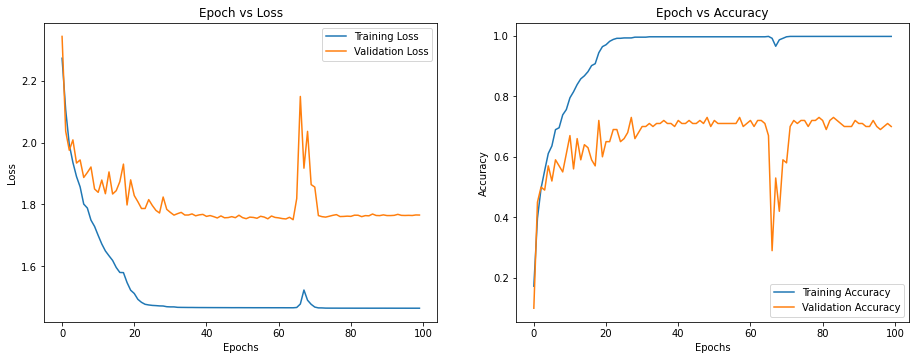

In [13]:
# Run training.

#Define parameters.
conv_params = {
    'padding': 1,
    'stride' : 1,
    'dilation': 1, #Dejar asi 
    'kernel_size': 3
}
learning_rate = 0.0001
epochs = 100  
nro_genres = 10
input_channel = 3
convfilters = [8,16,32,64,128, 256]
#------––----------------------------------------------------------------------------------------------------------------
# Run training.
model = music_net(input_channel, convfilters,conv_params, nro_genres).to(device)
train_loss, train_acc, validation_loss, validation_acc, best_model = train(model, device, train_loader, val_loader,epochs, learning_rate)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

#-----
best_val_acc = validation_acc[-1]
model_name = f"2CCN2FSinNada_model_{best_val_acc}.pth"
torch.save(best_model.state_dict(), model_name)

#summary(net, (BATCH_SIZE, 3, 288, 432), col_names=( "input_size", "output_size"))

In [14]:
print(best_val_acc)

0.7
